In [1]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import cPickle as pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.misc import imread
from scipy.misc import imresize
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Input, ZeroPadding2D,merge,Lambda
from keras.layers.convolutional import Convolution2D
from keras.models import Model
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.optimizers import SGD
from keras import backend as K
from keras.engine import Layer
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from keras.layers.core import  Lambda
from keras.regularizers import l2
#}

Using Theano backend.


In [2]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [3]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        img = imread(im_path, mode='RGB')
        #print im_path
        #print img.shape
        if img_size:
            img = imresize(img, img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode == 'bgr':
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:, (img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2
            , (img_size[1] - crop_size[1]) // 2:(img_size[1] + crop_size[1]) // 2]

        img_list.append(img)

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print im_path
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [4]:
#Helper function to normalization across channels
K.set_image_dim_ordering('th')
def crosschannelnormalization(alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
    """
    This is the function used for cross channel normalization in the original
    Alexnet
    """
    def f(X):
        if K.image_dim_ordering()=='tf':
            b, r, c, ch = X.get_shape()
        else:
            b, ch, r, c = X.shape

        half = n // 2
        square = K.square(X)
        scale = k
        if K.image_dim_ordering() == 'th':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 2, 3, 1)), ((0,0),(half,half)))
            extra_channels = K.permute_dimensions(extra_channels, (0, 3, 1, 2))
            for i in range(n):
                scale += alpha * extra_channels[:, i:i+ch, :, :]
        if K.image_dim_ordering() == 'tf':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 3, 1, 2)), (half, 0))
            extra_channels = K.permute_dimensions(extra_channels, (0, 2, 3, 1))
            for i in range(n):
                scale += alpha * extra_channels[:, :, :, i:i+int(ch)]
        scale = scale ** beta
        return X / scale


    return Lambda(f, output_shape=lambda input_shape: input_shape, **kwargs)

In [5]:
#Helper Function to split tensor
def splittensor(axis=1, ratio_split=1, id_split=0, **kwargs):
    def f(X):
        div = K.shape(X)[axis] // ratio_split

        if axis == 0:
            output = X[id_split*div:(id_split+1)*div, :, :, :]
        elif axis == 1:
            output = X[:, id_split*div:(id_split+1)*div, :, :]
        elif axis == 2:
            output = X[:, :, id_split*div:(id_split+1)*div, :]
        elif axis == 3:
            output = X[:, :, :, id_split*div:(id_split+1)*div]
        else:
            raise ValueError("This axis is not possible")
        return output

    def g(input_shape):
        output_shape = list(input_shape)
        output_shape[axis] = output_shape[axis] // ratio_split
        return tuple(output_shape)


    return Lambda(f, output_shape=lambda input_shape: g(input_shape), **kwargs)

In [6]:
#Alexnet layer architecture class
def AlexNet(img_shape=(3, 227, 227), n_classes=1000, l2_reg=0.,weights_path=None):

    dim_ordering = K.image_dim_ordering()
    print dim_ordering
    if dim_ordering == 'th':
        batch_index = 0
        channel_index = 1
        row_index = 2
        col_index = 3
    if dim_ordering == 'tf':
        batch_index = 0
        channel_index = 3
        row_index = 1
        col_index = 2

    inputs = Input(img_shape)

    conv_1 = Convolution2D(96, 11, 11, subsample=(4, 4), activation='relu',
                           name='conv_1', W_regularizer=l2(l2_reg))(inputs)

    conv_1_mask = np.ones(shape=((96, 55, 55)))
    conv_1_mask  = K.variable(conv_1_mask)
    conv_1_lambda = Lambda(lambda x: x * conv_1_mask)(conv_1)

    conv_2 = MaxPooling2D((3, 3), strides=(2, 2))(conv_1_lambda)
    conv_2 = crosschannelnormalization(name="convpool_1")(conv_2)
    conv_2 = ZeroPadding2D((2, 2))(conv_2)
    conv_2 = merge([
        Convolution2D(128, 5, 5, activation="relu", name='conv_2_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_2)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_2")

    conv_2_mask = np.ones(shape=((256, 27, 27)))
    conv_2_mask = K.variable(conv_2_mask)
    conv_2_lambda = Lambda(lambda x: x * conv_2_mask)(conv_2)

    conv_3 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2_lambda)
    conv_3 = crosschannelnormalization()(conv_3)
    conv_3 = ZeroPadding2D((1, 1))(conv_3)
    conv_3 = Convolution2D(384, 3, 3, activation='relu', name='conv_3',
                           W_regularizer=l2(l2_reg))(conv_3)

    conv_3_mask = np.ones(shape=((384, 13, 13)))
    conv_3_mask = K.variable(conv_3_mask)
    conv_3_lambda = Lambda(lambda x: x * conv_3_mask)(conv_3)

    conv_4 = ZeroPadding2D((1, 1))(conv_3_lambda)
    conv_4 = merge([
        Convolution2D(192, 3, 3, activation="relu", name='conv_4_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_4)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_4")

    conv_4_mask = np.ones(shape=((384, 13, 13)))
    conv_4_mask = K.variable(conv_4_mask)
    conv_4_lambda = Lambda(lambda x: x * conv_4_mask)(conv_4)

    conv_5 = ZeroPadding2D((1, 1))(conv_4_lambda)
    conv_5 = merge([
        Convolution2D(128, 3, 3, activation="relu", name='conv_5_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_5)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_5")

    conv_5_mask = np.ones(shape=((256, 13, 13)))
    conv_5_mask = K.variable(conv_5_mask)
    conv_5_lambda = Lambda(lambda x: x * conv_5_mask)(conv_5)

    dense_1 = MaxPooling2D((3, 3), strides=(2, 2), name="convpool_5")(conv_5_lambda)

    dense_1 = Flatten(name="flatten")(dense_1)
    dense_1 = Dense(4096, activation='relu', name='dense_1',
                    W_regularizer=l2(l2_reg))(dense_1)

    dense_1_mask = np.ones(shape=((4096,)))
    dense_1_mask = K.variable(dense_1_mask)
    dense_1_lambda = Lambda(lambda x: x * dense_1_mask)(dense_1)

    dense_2 = Dropout(0.5)(dense_1_lambda)
    dense_2 = Dense(4096, activation='relu', name='dense_2',
                    W_regularizer=l2(l2_reg))(dense_2)

    dense_2_mask = np.ones(shape=((4096,)))
    dense_2_mask = K.variable(dense_2_mask)
    dense_2_lambda = Lambda(lambda x: x * dense_2_mask)(dense_2)

    dense_3 = Dropout(0.5)(dense_2_lambda)
    if n_classes == 1000:
        dense_3 = Dense(n_classes, name='dense_3',
                        W_regularizer=l2(l2_reg))(dense_3)
        dense_3_mask = np.ones(shape=((1000,)))
        dense_3_mask = K.variable(dense_3_mask)
        dense_3_lambda = Lambda(lambda x: x * dense_3_mask)(dense_3)
    else:
        # We change the name so when loading the weights_file from a
        # Imagenet pretrained model does not crash
        dense_3 = Dense(n_classes, name='dense_3_new',
                        W_regularizer=l2(l2_reg))(dense_3)
        dense_3_mask = np.ones(shape=((1000,)))
        dense_3_mask = K.variable(dense_3_mask)
        dense_3_lambda = Lambda(lambda x: x * dense_3_mask)(dense_3)

    prediction = Activation("softmax", name="softmax")(dense_3_lambda)

    model = Model(input=inputs, output=prediction)
    if weights_path:
        model.load_weights(weights_path)

    return model

In [7]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:n_max_synsets]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
        print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids


In [8]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5")
model.compile(optimizer=sgd, loss='mse')

th


In [155]:
# Prepare the image list and pre-process them{
im_list = []

url_path = '../../data/92_image/animate/'
for i in os.listdir(url_path):
    if not i.startswith('~') and not i.startswith('.'):
        temp = i.split('.')[0]
        im_list.append(url_path+i)

url_path = '../../data/92_image/inanimate/'
for i in os.listdir(url_path):
    if not i.startswith('~') and not i.startswith('.'):
        temp = i.split('.')[0]
        im_list.append(url_path+i)
        

im = preprocess_image_batch(im_list,img_size=(256,256), crop_size=(227,227), color_mode="rgb")
#}

#out = model.predict(im,batch_size=64)
#print im_list, pprint_output(out[0])

# Code snippet to get the activation values and saving information{
flag  = 0
i = 0
result ={}
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        activations = get_activations(model,i,im)
        if result.get(layer.name, None) is None:
            result[layer.name] = activations[0]
            if layer.name == 'conv_1b':
                print layer.name,len(weights),len(activations), activations[0].shape, activations[0][0].ravel().shape, np.mean(activations[0], axis=0).shape
                for j in range(activations[0].shape[0]):
                    temp = activations[0][j].ravel()
                    if flag == 0:
                        data = temp
                        flag = 1
                    else:
                        #print(j, data.shape)
                        data = np.vstack((data,temp))
            elif layer.name == 'conv_5_1b' or layer.name == 'conv_5_2b':
                print layer.name,len(weights),len(activations), activations[0].shape, activations[0][0].ravel().shape, np.mean(activations[0], axis=0).shape
                for j in range(activations[0].shape[0]):
                    temp = activations[0][j].ravel()
                    if layer.name == 'conv_5_2':
                        #print data[j].shape, temp.shape
                        temp2 = np.append(data[j],temp)
                        if flag == 2:
                            data1 = temp2
                            flag = 1
                        else:
                            data1 = np.vstack((data1,temp2))
                    elif flag == 0:
                        data = temp
                        flag = 1
                    else:
                        #print(j, data.shape)
                        data = np.vstack((data,temp))
                        flag = 2
            elif layer.name =='dense_3':
                temp = np.mean(activations[0], axis=0).ravel()
                print layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape
                data = activations[0]
    i += 1

#}
#data = data1
print(data.shape)

dense_3 2 1 (92, 1000) (1000,) (1000,)
(92, 1000)


In [156]:
from scipy.stats import percentileofscore
import pandas as pd

correlation_mat= 1 - np.corrcoef(data)
data_shape = correlation_mat.shape
arr_sorted =  sorted(correlation_mat.ravel())
s = pd.Series(correlation_mat.ravel())
percentiles = np.asarray(s.apply(lambda x: percentileofscore(arr_sorted, x)))
print(percentiles.shape)
data = np.reshape(percentiles, data_shape)
print(data.shape)

(8464,)
(92, 92)


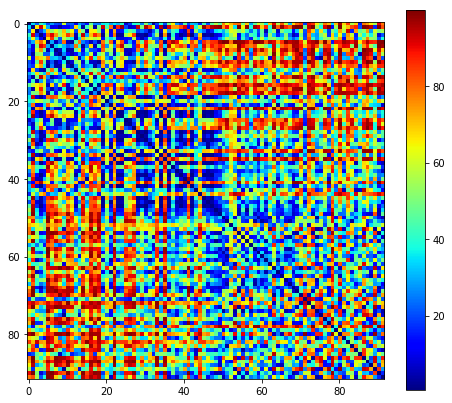

In [157]:
# plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))

plt.imshow(
    data, 
    cmap='jet', 
)
plt.colorbar()

In [37]:
# Model parmeters and running the model from the loaded weights{

image1 = '../../data/92_image/animate/1.jpeg'


im1 = preprocess_image_batch([image1],img_size=(256,256), crop_size=(227,227), color_mode="rgb")

out = model.predict(im1,batch_size=64)
print image1, pprint_output(out[0])

# Code snippet to get the activation values and saving information{
data1 = np.array([])

i = 0
result ={}
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        activations = get_activations(model,i,im1)
        if result.get(layer.name, None) is None:
            result[layer.name] = activations[0]
            temp = np.mean(activations[0], axis=0).ravel()
            if layer.name == 'dense_2':
                print layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape
                data1 = np.append(data1, temp)
    i += 1

#}

../../data/92_image/animate/1.jpeg 4.74 : Band Aid n02786058
3.33 : spatula n04270147
3.13 : panpipe, pandean pipe, syrinx n03884397
2.62 : swimming trunks, bathing trunks n04371430
1.90 : knee pad n03623198
1.90 : Windsor tie n04591157
1.67 : conch n01943899
1.60 : paintbrush n03876231
1.43 : ballpoint, ballpoint pen, ballpen, Biro n02783161
1.22 : matchstick n03729826
['n02786058', 'n04270147', 'n03884397', 'n04371430', 'n03623198', 'n04591157', 'n01943899', 'n03876231', 'n02783161', 'n03729826']
dense_2 2 1 (1, 4096) (4096,) (4096,)


In [38]:
# Model parmeters and running the model from the loaded weights{

image2 = '../../data/92_image/animate/2.jpeg'


im2 = preprocess_image_batch([image2],img_size=(256,256), crop_size=(227,227), color_mode="rgb")

out = model.predict(im2,batch_size=64)
print image2, pprint_output(out[0])

# Code snippet to get the activation values and saving information{
data2 = np.array([])

i = 0
result ={}
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        activations = get_activations(model,i,im2)
        if result.get(layer.(0.0689424439775071, 2.2624702146415126e-11)name, None) is None:
            result[layer.name] = activations[0]
            temp = np.mean(activations[0], axis=0).ravel()
            if layer.name == 'dense_2':
                print layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape
                data2 = np.append(data2, temp)
    i += 1

#}

../../data/92_image/animate/2.jpeg 3.94 : ocarina, sweet potato n03840681
2.03 : Band Aid n02786058
2.03 : loupe, jeweler's loupe n03692522
1.61 : ski mask n04229816
1.56 : knee pad n03623198
1.30 : mask n03724870
1.25 : switch, electric switch, electrical switch n04372370
1.15 : face powder n03314780
1.14 : black-footed ferret, ferret, Mustela nigripes n02443484
1.10 : pick, plectrum, plectron n03929660
['n03840681', 'n02786058', 'n03692522', 'n04229816', 'n03623198', 'n03724870', 'n04372370', 'n03314780', 'n02443484', 'n03929660']
dense_2 2 1 (1, 4096) (4096,) (4096,)


In [41]:
X = np.vstack((data1,data2))
X.shape

(3, 4096)

In [65]:
#Imports
import cPickle as pickle
from scipy.io import loadmat

In [ ]:
with open('../../data/pkl/92_animate_test.pkl', 'rb') as f:
     animate_data = pickle.load(f)
        
with open('../../data/pkl/92_animate_test.pkl', 'rb') as f:
     inanimate_data = pickle.load(f)

In [66]:
mat = loadmat('../../data/supplementalData_hmIT92.mat')
monkeyIT = list(mat['RDMs_mIT_hIT_fig1'][0][0][2][0])
humanIT = list(mat['RDMs_mIT_hIT_fig1'][0][1][2][0])

In [158]:
correlation_mat= 1 - np.corrcoef(data)
print(correlation_mat.shape)
upper = correlation_mat[np.triu_indices(92,1)]
print(upper.shape)

import scipy.stats as stats
tau, p_value = stats.kendalltau(upper, humanIT)
print(tau, p_value)


(92, 92)
(4186,)
(0.1163880740318328, 1.4600168865814578e-29)


In [ ]:
#48-Animate 44-Inanimate

count = 0
for i in range(1,93,1):
    for j in range(i+1,93,1):
        count+=1
count

In [ ]:
'''
conv_1 (0.0689424439775071, 2.2624702146415126e-11)
conv_2 (0.06029668217606506, 4.936915320978156e-09)
conv_3 (0.07210368977549902, 2.6589616431347935e-12)(0.08234594349601361, 1.3686963826603831e-15)
conv_4 (0.08234594349601361, 1.3686963826603831e-15)
conv_5 (0.07122689787486422, 4.8599677685919544e-12)
dense_1 (0.10675729132952133, 3.9160580474696687e-25)
dense_2 (0.12747172831324305, 4.0006531221043654e-35)
dense_3 (0.1163880740318328, 1.4600168865814578e-29)
'''

Text(0.5,0,'Individual Layers of Alexnet')

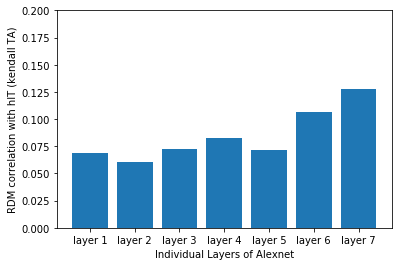

In [162]:
x = np.arange(7)
tau = [0.0689424439775071,0.06029668217606506,0.07210368977549902,0.08234594349601361, 0.07122689787486422,0.10675729132952133,0.12747172831324305]

fig, ax = plt.subplots()
plt.bar(x, tau)
plt.xticks(x, ('layer 1', 'layer 2', 'layer 3', 'layer 4', 'layer 5','layer 6','layer 7'))
plt.ylim([0,0.2])
plt.ylabel('RDM correlation with hIT (kendall TA)')
plt.xlabel('Individual Layers of Alexnet')

(92, 92)

Text(0.5,0,'Individual Layers of Alexnet')

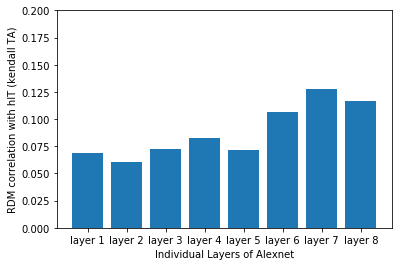

In [161]:
x = np.arange(8)
tau = [0.0689424439775071,0.06029668217606506,0.07210368977549902,0.08234594349601361, 0.07122689787486422,0.10675729132952133,0.12747172831324305,0.1163880740318328]

fig, ax = plt.subplots()
plt.bar(x, tau)
plt.xticks(x, ('layer 1', 'layer 2', 'layer 3', 'layer 4', 'layer 5','layer 6','layer 7', 'layer 8'))
plt.ylim([0,0.2])
plt.ylabel('RDM correlation with hIT (kendall TA)')
plt.xlabel('Individual Layers of Alexnet')